# DBSCAN

We implement the DBSCAN algorithm in this notebook.

### Imports 

In [1]:
import os
import time
import pandas as pd
import geopandas as gpd
import preprocessor as p
from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon

### Read in the data

In [2]:
# Set data directory
data_dir = os.path.realpath("../data")

# Check if file exists
if os.path.exists(os.path.join(data_dir, "tweets.h5")):
    # Read tweets from htweets5
    tweets = pd.read_hdf(os.path.join(data_dir, "tweets.h5"), "tweets")
else:
    # Convert tweets to htweets5
    # ? hdf manages large data well
    tweets = pd.read_csv(os.path.join(data_dir, "tweets.csv"))
    tweets.to_hdf(os.path.join(data_dir, "tweets.h5"), "tweets")

### Data Preprocessing

In [3]:
# Remove duplicates
tweets.drop_duplicates(subset="wikidata", inplace=True)

# Remove null longitude and latitude values
tweets = tweets[tweets["longitude"].notnull()]

# Constrain the area to France
tweets = tweets.loc[
    (tweets.latitude > 42.33278)
    & (tweets.latitude < 51.08917)
    & (tweets.longitude > -4.795556)
    & (tweets.longitude < 8.230556)
]

# Set preprocessor options
p.set_options(p.OPT.URL)

# Remove URLs from the tweets
tweets['text'] = tweets['text'].apply(lambda x: p.clean(x))

# Order tweets by createdAt
tweets.sort_values(by="createdAt", inplace=True)

# Set id as index
tweets["id"] = range(1, len(tweets) + 1)
tweets.set_index('id', inplace=True, verify_integrity=False)

# Remove columns that are not needed
tweets.drop(columns=['tweetId', 'mention', 'start', 'end', 'wikidata', 'altitude', 'osm', 'geonames'], inplace=True)

In [4]:
tweets.head()

,createdAt,entity,longitude,latitude,text
id,,,,,
1,2019-11-11T10:55:21Z,Saint-Genest-Malifaux,4.419722,45.340000,C'est moi où il y a eu un mini tremblement de ...
2,2019-11-11T10:56:12Z,Pont-Saint-Esprit,4.648333,44.256389,Vous avez senti le tremblement de terre à Pont...
3,2019-11-11T10:56:57Z,Uzès,4.419722,44.012500,Tremblement de terre à Uzès à l’instant ! Je r...
4,2019-11-11T10:57:15Z,Mende (Lozère),3.500556,44.518333,Y’a eu un tremblement de terre dans ma ville 😭
5,2019-11-11T10:57:44Z,Oullins,4.807500,45.714167,Petit tremblement de terre sur Oullins de 5’’ ...


In [5]:
# Convert lat and long to numpy array
COORDS = tweets[['longitude', 'latitude']].values

# Set DBSCAN parameters
# ? Higher minsamples or lower eps indicate higher density necessary to form a cluster
# ? On noisy and large datasets, higher min_samples is better
EPS = 0.8
MIN_SAMPLES = 5

# Start timer
start = time.time()

# Create DBSCAN model
# ? Noise is labeled -1
db = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES).fit(COORDS)

# End timer
end = time.time()

# Print time taken
print("Time taken: {} seconds".format(end - start))

# Print number of clusters
print("Number of clusters: {}".format(len(set(db.labels_))))

# Store labels in tweets
tweets['cluster'] = db.labels_

Time taken: 0.0030052661895751953 seconds
Number of clusters: 5


In [6]:
# Create a hulls geodataframe
hulls = gpd.GeoDataFrame(columns=['cluster', 'geometry'])

for cluster in set(db.labels_):
    if cluster != -1:
        # Get the coordinates of the points in the cluster
        points = COORDS[db.labels_ == cluster]
        # Create a convex hull
        hull = ConvexHull(points)
        # Append the cluster and hull to the geodataframe using concat instead of append
        hulls = pd.concat([hulls, gpd.GeoDataFrame({
            'cluster': [cluster],
            'geometry': [Polygon(points[hull.vertices])]
        })], ignore_index=True)

hulls.set_crs(epsg=4326, inplace=True)

,cluster,geometry
0,0,"POLYGON ((2.43972 44.92528, 3.16667 43.66667, ..."
1,1,"POLYGON ((2.58667 49.20722, 2.27139 48.83890, ..."
2,2,"POLYGON ((1.44389 43.60444, 1.95278 42.44667, ..."
3,3,"POLYGON ((7.76806 48.58333, 7.50000 48.50000, ..."


In [7]:
# Read France geojson
france = gpd.read_file(filename='../data/france.geojson')

# Convert tweets to geodataframe
tweets_gdf = gpd.GeoDataFrame(
    tweets,
    geometry=gpd.points_from_xy(tweets.longitude, tweets.latitude),
    crs="EPSG:4326"
)

Text(0.5, 1.0, 'DBSCAN Clustering of Tweets in France')

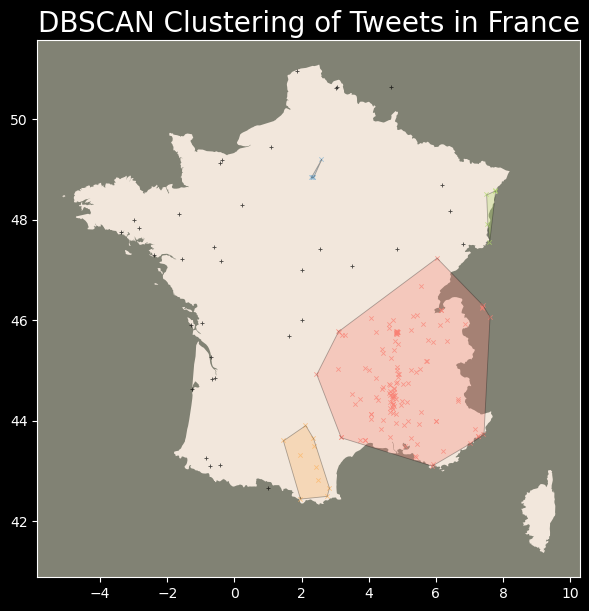

In [8]:
# Plot base map
base = france.plot(color='#F2E7DC', figsize=(7, 7), linewidth=0)
base.set_facecolor('#818274')

# Plot tweets with cluster labels with different markers
for cluster in tweets_gdf.cluster.unique():
    tweets_gdf[tweets_gdf.cluster == cluster].plot(
        ax=base,
        markersize=10,
        label='NOISE' if cluster == -1 else 'Cluster {}'.format(cluster),
        alpha=0.7,
        # linewidth=0.6,
        marker='x' if cluster != -1 else '+',
        color='black' if cluster == -1 else 'C{}'.format(cluster + 3),
        linewidth=0.6,
    )
    
for cluster in hulls.cluster:
    hulls[hulls.cluster == cluster].plot(
        ax=base,
        alpha=0.3,
        color='C{}'.format(cluster + 3),
        edgecolor='black',
        linewidth=0.6,
    )

# Set title
base.set_title("DBSCAN Clustering of Tweets in France", fontsize=20)

In [9]:
# Save figure
base.get_figure().savefig('../images/dbscan.png', dpi=300)